# Markov modeling of peptide folding in the presence of protein crowders
Author: Daniel Nilsson, Computational Biology and Biological Physics, Department of Astronomy and Theoretical Physics, Lund University

A major challenge in modern biophysics research is to understand how the presence of macromolecules affects the function of proteins in the crowded cellular interior. In this project, we study the folding of a peptide in the presence of macromolecular crowders by means of Monte Carlo (MC) simulations and Markov state modeling. This notebook contains the calculations performed during the Markov state modeling part of the study, and starts by loading in the simulation results.

The simulated systems consist of one GB1m3 molecule and eight crowder molecules, enclosed in a periodic box with side length 95Å. The eight crowder molecules were copies of a single protein, either BPTI or GB1m3. The simulations were performed at a temperature of 332K, which is close to the GB1m3 melting temperature. Simulations of the free GB1m3 peptide were also performed, at the same temperature.

As mentioned, the systems were simulated using MC dynamics, in the canonical ensemble. To avoid artificial jumps between free energy minima, only "small-step" elementary moves were used. Despite this, the simulations are fast enough to permit a statistically robust study of the folding and binding thermodynamics of the peptide, with multiple independent folding/unfolding and binding/unbinding events.

All simulations were performed with the program [PROFASI](http://cbbp.thep.lu.se/activities/profasi/), v. 1.92. For each system a number of independent runs were generated (16 with BPTI crowders, 62 with GB1 crowders, and 30 for the free peptide). The subsequent Markov model analysis was performed using the [pyEMMA](http://emma-project.org/latest/index.html) software.

In [1]:
%pylab inline
import os
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt

Populating the interactive namespace from numpy and matplotlib


/home/st08/danieln/anaconda3/lib/python3.5/site-packages/pyemma/__init__.py:91: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.4, you have 2.3.2.
  .format(latest=latest, current=current), category=UserWarning)


In [2]:
rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman'],'size':15})
rc('text', usetex=True)

 The below code extracts data from these runs and converts it to .npy format, in order to reduce file sizes, and to make the later parts of the analysis manageable without loading huge matrices.

Note that the data at all steps take up quite a large amount of memory (>20GB), and as such will not be distributed along with this notebook. It can be provided on request however.

In [3]:
# Number of trajectories for each system
Nfree=30
NBPTI=16
NGB1=16

In [ ]:
%%bash

module load PROFASI/V192

mkdir free/ca-dists_all

for i in {0..29}; do 
    cp data/free/settings_ca-dists.cnf settings.cnf
    extract_props data/free/n$i/traj --settings_file -rt; mv rt data/free/ca-dists_all/rt$i; 
    cp data/free/settings_few-vars.cnf settings.cnf
    extract_props data/free/n$i/traj --settings_file -rt; mv rt data/free/few-vars/rt$i; 
done

mkdir BPTI/ca-dists_all

for i in {0..15}; do 
    cp data/BPTI/settings_ca-dists.cnf settings.cnf
    extract_props data/BPTI/n$i/traj --settings_file -rt; mv rt data/BPTI/ca-dists_all/rt$i; 
    cp BPTI/settings_few-vars.cnf settings.cnf
    extract_props data/BPTI/n$i/traj --settings_file -rt; mv rt data/BPTI/few-vars/rt$i; 
done

mkdir GB1/ca-dists_all

for i in {0..61}; do 
    cp data/GB1/settings_ca-dists.cnf settings.cnf
    extract_props data/GB1/n$i/traj --settings_file -rt; mv rt data/GB1/ca-dists_all/rt$i; 
    cp data/GB1/settings_few-vars.cnf settings.cnf
    extract_props data/GB1/n$i/traj --settings_file -rt; mv rt data/GB1/few-vars/rt$i; 
done

In [ ]:
# Each rt-file contains the trajectory of one simulation. The first 13 fields are 
# automatically included. We are not interested in these. The next 105 fields are 
# intramolecular distances and should all be included. The remaining fields are 
# intermolecular distances between test peptide and crowders. For each crowder residue,
# we keep only the minimum of the eight equivalent distances.

for i in range(Nfree):
    arr=np.loadtxt("data/free/ca-dists_all/rt%i"%i)
    narr=numpy.zeros((arr.shape[0],105+(arr.shape[1]-118)//8))
    narr[:,:105]=arr[:,13:118]
    for j in range((arr.shape[1]-118)//8):
        narr[:,105+j]=numpy.amin(arr[:,118+8*j:126+8*j],axis=1)
    np.save("data/free/ca-dists_all/rt%i_pruned.npy" %i, narr)

for i in range(NBPTI):
    arr=np.loadtxt("data/BPTI/ca-dists_all/rt%i"%i)
    narr=numpy.zeros((arr.shape[0],105+(arr.shape[1]-118)//8))
    narr[:,:105]=arr[:,13:118]
    for j in range((arr.shape[1]-118)//8):
        narr[:,105+j]=numpy.amin(arr[:,118+8*j:126+8*j],axis=1)
    np.save("data/BPTI/ca-dists_all/rt%i_pruned.npy" %i, narr)
    
for i in range(NGB1):
    arr=np.loadtxt("data/GB1/ca-dists_all/rt%i"%i)
    narr=numpy.zeros((arr.shape[0],105+(arr.shape[1]-118)//8))
    narr[:,:105]=arr[:,13:118]
    for j in range((arr.shape[1]-118)//8):
        narr[:,105+j]=numpy.amin(arr[:,118+8*j:126+8*j],axis=1)
    np.save("data/GB1/ca-dists_all/rt%i_pruned.npy" %i, narr)

In [8]:
# Move data with common variables to .npy files.
%mkdir few-vars
free_fv=[]
for i in range(Nfree):
    free_fv.append(numpy.loadtxt("data/free/n%i/rt"%i, usecols=(13,)))
np.save('data/few-vars/free.npy',free_fv)

BPTI_fv=[]
for i in range(NBPTI):
    BPTI_fv.append(numpy.loadtxt("data/BPTI/few-vars/rt%i"%i, usecols=(13,251)))
np.save('data/few-vars/BPTI.npy',BPTI_fv)

GB1_fv=[]
for i in range(NGB1):
    GB1_fv.append(numpy.loadtxt("data/GB1/few-vars/rt%i"%i, usecols=(13,243,246)))
np.save('data/few-vars/GB1.npy',GB1_fv)

mkdir: cannot create directory ‘few-vars’: File exists


In [16]:
# Load simulation data
free=[]
for i in range(Nfree):
    free.append(numpy.load("data/free/ca-dists_all/rt%i_pruned.npy" % i, mmap_mode='r'))
    
BPTI=[]
for i in range(NBPTI):
    BPTI.append(numpy.load("data/BPTI/ca-dists_all/rt%i_pruned.npy" % i, mmap_mode='r'))
    
GB1=[]
for i in range(NGB1):
    GB1.append(numpy.load("data/GB1/ca-dists_all/rt%i_pruned.npy" % i, mmap_mode='r'))

# Time-lagged independent component analysis
We begin our analysis by performing a [time-lagged independent component analysis](http://aip.scitation.org/doi/abs/10.1063/1.4811489) (TICA). TICA can be used as a dimensionality reduction method, similar to PCA. However, TICA detects high-autocorrelation (or slow), rather than high-variance coordinates. Based on trajectories of a set of observables, $\{o_n\}$, one may construct the time-lagged covariance matrix 

$$c_{nm}(\tau_\mathrm{cm})=\langle o_n(t)o_m(t+\tau_\mathrm{cm})\rangle_t - \langle o_n(t)\rangle_t\langle o_m(t+\tau_\mathrm{cm})\rangle_t, $$

where the lag time $\tau_\mathrm{cm}$ is a freely chosen parameter, and $\langle\cdot\rangle_t$ denotes time average. The TICs are found by solving the generalized eigenvalue problem 

$$\mathsf{C}(\tau_\mathrm{cm})\mathbf{v}_i=\lambda_i\mathsf{C}(0)\mathbf{v}_i,$$

and selecting those directions with largest autocorrelations $\lambda_i$.

As previously mentioned, the input data set is large, and as such is not distributed along with this notebook. We therefore save the TICA output as .npy files, which will be distributed.

In [18]:
%mkdir TICA-trajs
#No crowders
tica_obj=coor.tica(free, lag=1, dim=10)
Y=tica_obj.get_output()
numpy.save('data/TICA-trajs/free.npy',Y)
    
#BPTI crowders
tica_obj=coor.tica(BPTI, lag=1, dim=10)
Y=tica_obj.get_output()
numpy.save('data/TICA-trajs/BPTI.npy',Y)
    
#GB1 crowders
tica_obj=coor.tica(GB1, lag=20, dim=10)
Y=tica_obj.get_output()
numpy.save('data/TICA-trajs/GB1.npy',Y)

The below code generates figures of the free energy as a function of the first few TICs. In order to establish a connection to some more commonly used observables, the averages of these observables are plotted as functions of the same TICs.

In [9]:
def bin_data(x,y,z,nbins=100):
    xmin=numpy.min(x)
    xmax=numpy.max(x)
    dx=(xmax-xmin)/nbins
    
    ymin=numpy.min(y)
    ymax=numpy.max(y)
    dy=(ymax-ymin)/nbins
    
    ext=[xmin,xmax,ymin,ymax]
    
    xbins=numpy.linspace(xmin-0.5*dx,xmax+0.5*dx,num=nbins)
    ybins=numpy.linspace(ymin-0.5*dy,ymax+0.5*dy,num=nbins)
    xI=numpy.digitize(x,xbins)
    yI=numpy.digitize(y,ybins)
    
    zbinned=numpy.zeros((nbins,nbins))
    N=numpy.zeros((nbins,nbins))

    for t in range(len(x)):
        zbinned[xI[t],yI[t]]+=z[t]
        N[xI[t],yI[t]]+=1.
    with warnings.catch_warnings() as cm:
        warnings.simplefilter('ignore')
        zbinned/=N
    return zbinned,ext

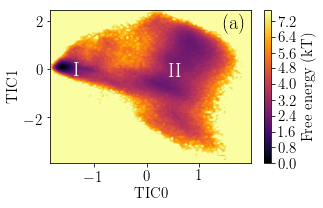

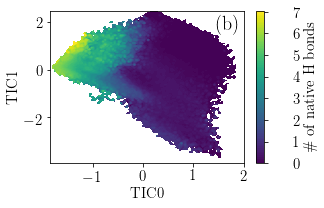

In [43]:
# No crowders

# Load TICA trajectories
Y=np.load('data/TICA-trajs/free.npy')
tic0 = numpy.vstack(Y)[:,0]
tic1 = numpy.vstack(Y)[:,1]

# Load trajectories of folding variable
fv=np.load('data/few-vars/free.npy')
fold=numpy.hstack(fv)

# Plot free energy
fig=plt.figure(figsize=(12/2.54,8/2.54))
ax=plt.axes()
mplt.plot_free_energy(tic0, tic1,ax=ax,cmap='inferno',cbar=True);
ax.set_xlabel('TIC0')
ax.set_ylabel('TIC1')
ax.text(-1.4, -.25, 'I', fontsize=20, color='white')
ax.text(.4, -.3, 'II', fontsize=20, color='white')
ax.text(1.45,1.7, '(a)', fontsize=20, color='black')

plt.tight_layout()
plt.savefig("figs/free_en_free.pdf")
plt.show()
plt.gcf().clear()

# Plot folding variable
fig=plt.figure(figsize=(12/2.54,8/2.54))
ax=plt.axes()

z,ext=bin_data(tic0,tic1,fold)

c=ax.contourf(z.T, 100, extent=ext)

cbar = matplotlib.pyplot.colorbar(c, ax=ax)
cbar.ax.set_ylabel('\# of native H bonds')
cbar.set_ticks(np.arange(0,8,1))
yticklabs=cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(yticklabs,ha='right')
cbar.ax.yaxis.set_tick_params(pad=33)

ax.set_aspect('auto')
ax.set_xlabel('TIC0')
ax.set_ylabel('TIC1')
ax.text(1.45,1.7, '(b)', fontsize=20, color='black')

plt.tight_layout()
plt.savefig("figs/modes_folding_free.pdf")
plt.show()
plt.gcf().clear()

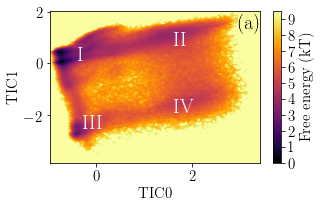

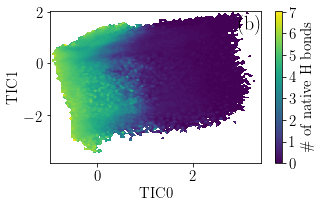

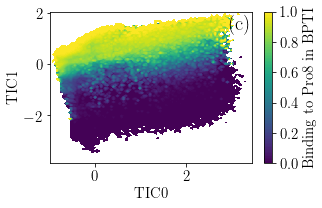

In [72]:
# BPTI crowders

# Load TICA trajectories
Y=np.load('data/TICA-trajs/BPTI.npy')
tic0 = numpy.vstack(Y)[:,0]
tic1 = numpy.vstack(Y)[:,1]

# Load trajectories of folding variable
fv=np.load('data/few-vars/BPTI.npy')
fold=numpy.vstack(fv)[:,0]
bind=(numpy.vstack(fv)[:,1]>0).astype(int)

fig=plt.figure(figsize=(12/2.54,8/2.54))
ax=plt.axes()
mplt.plot_free_energy(tic0, tic1,ax=ax,cbar=True,cmap='inferno');
ax.set_xlabel('TIC0')
ax.set_ylabel('TIC1')
ax.text(-.4, 0.1, 'I', fontsize=20, color='white')
ax.text(1.6, .7, 'II', fontsize=20, color='white')
ax.text(-.3, -2.5, 'III', fontsize=20, color='white')
ax.text(1.6, -1.9, 'IV', fontsize=20, color='white')
ax.text(2.95,1.35, '(a)', fontsize=20, color='black')
plt.tight_layout()
plt.savefig("figs/free_en_BPTI.pdf")
plt.show()
plt.gcf().clear()

# Plot folding variable
fig=plt.figure(figsize=(12/2.54,8/2.54))
ax=plt.axes()

z,ext=bin_data(tic0,tic1,fold)
c=ax.contourf(z.T, 100, extent=ext)

cbar = matplotlib.pyplot.colorbar(c, ax=ax)
cbar.ax.set_ylabel('\# of native H bonds')
cbar.set_ticks(np.arange(0,8,1))
yticklabs=cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(yticklabs,ha='right')
cbar.ax.yaxis.set_tick_params(pad=11)

ax.set_aspect('auto')
ax.set_xlabel('TIC0')
ax.set_ylabel('TIC1')
ax.text(2.94,1.35, '(b)', fontsize=20, color='black')

plt.tight_layout()
plt.savefig("figs/modes_folding_BPTI.pdf")
plt.show()
plt.gcf().clear()

# Plot binding variable
fig=plt.figure(figsize=(12/2.54,8/2.54))
ax=plt.axes()

z,ext=bin_data(tic0,tic1,bind)
c=ax.contourf(z.T, 100, extent=ext)

cbar = matplotlib.pyplot.colorbar(c, ax=ax)
cbar.ax.set_ylabel('Binding to Pro8 in BPTI')
cbar.set_ticks(np.arange(0,1.2,.2))
yticklabs=cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(yticklabs,ha='right')
cbar.ax.yaxis.set_tick_params(pad=23)

ax.set_aspect('auto')
ax.set_xlabel('TIC0')
ax.set_ylabel('TIC1')
ax.text(2.95,1.35, '(c)', fontsize=20, color='black')

plt.tight_layout()
plt.savefig("figs/modes_binding_BPTI.pdf")
plt.show()
plt.gcf().clear()

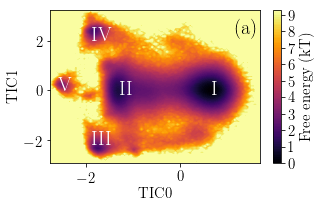

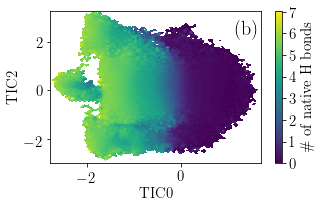

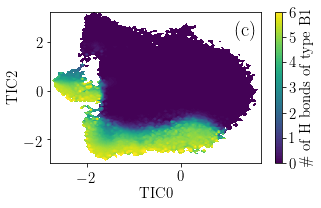

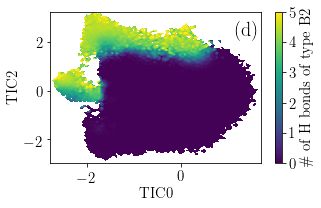

In [73]:
# GB1 crowders (TIC0-TIC2)

# Load TICA trajectories
Y=np.load('data/TICA-trajs/GB1.npy')
tic0 = numpy.vstack(Y)[:,0]
tic1 = numpy.vstack(Y)[:,1]
tic2 = numpy.vstack(Y)[:,2]

# Load trajectories of folding variable
fv=np.load('data/few-vars/GB1.npy')
fold=numpy.vstack(fv)[:,0]
bind1=numpy.vstack(fv)[:,1]
bind2=numpy.vstack(fv)[:,2]

# Plot free energy
fig=plt.figure(figsize=(12/2.54,8/2.54))
ax=plt.axes()
mplt.plot_free_energy(tic0, tic2,ax=ax,cbar=True,cmap='inferno');
ax.set_xlabel('TIC0')
ax.set_ylabel('TIC1')
ax.text(.65, -.15, 'I', fontsize=20, color='white')
ax.text(-1.3, -.15, 'II', fontsize=20, color='white')
ax.text(-1.9, -2.2, 'III', fontsize=20, color='white')
ax.text(-1.9, 2, 'IV', fontsize=20, color='white')
ax.text(-2.6, 0, 'V', fontsize=20, color='white')
ax.text(1.15,2.3, '(a)', fontsize=20, color='black')
plt.tight_layout()
plt.savefig("figs/free_en_GB1.pdf")
plt.show()
plt.gcf().clear()

# Plot folding variable
fig=plt.figure(figsize=(12/2.54,8/2.54))
ax=plt.axes()

z,ext=bin_data(tic0,tic2,fold)
c=ax.contourf(z.T, 100, extent=ext)

cbar = matplotlib.pyplot.colorbar(c, ax=ax)
cbar.ax.set_ylabel('\# of native H bonds')
cbar.set_ticks(np.arange(0,8,1))
yticklabs=cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(yticklabs,ha='right')
cbar.ax.yaxis.set_tick_params(pad=11)

ax.set_aspect('auto')
ax.set_xlabel('TIC0')
ax.set_ylabel('TIC2')
ax.text(1.15,2.3, '(b)', fontsize=20, color='black')

plt.tight_layout()
plt.savefig("figs/modes_folding_GB1.pdf")
plt.show()
plt.gcf().clear()

# Plot binding variable 1
fig=plt.figure(figsize=(12/2.54,8/2.54))
ax=plt.axes()

z,ext=bin_data(tic0,tic2,bind1)
c=ax.contourf(z.T, 100, extent=ext)

cbar = matplotlib.pyplot.colorbar(c, ax=ax)
cbar.ax.set_ylabel('\# of H bonds of type B1')
cbar.set_ticks(np.arange(0,7,1))
yticklabs=cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(yticklabs,ha='right')
cbar.ax.yaxis.set_tick_params(pad=11)

ax.set_aspect('auto')
ax.set_xlabel('TIC0')
ax.set_ylabel('TIC2')
ax.text(1.15,2.3, '(c)', fontsize=20, color='black')

plt.tight_layout()
plt.savefig("figs/modes_binding1_GB1.pdf")
plt.show()
plt.gcf().clear()

# Plot binding variable 2
fig=plt.figure(figsize=(12/2.54,8/2.54))
ax=plt.axes()

z,ext=bin_data(tic0,tic2,bind2)
c=ax.contourf(z.T, 100, extent=ext)

cbar = matplotlib.pyplot.colorbar(c, ax=ax)
cbar.ax.set_ylabel('\# of H bonds of type B2')
cbar.set_ticks(np.arange(0,6,1))
yticklabs=cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(yticklabs,ha='right')
cbar.ax.yaxis.set_tick_params(pad=11)

ax.set_aspect('auto')
ax.set_xlabel('TIC0')
ax.set_ylabel('TIC2')
ax.text(1.15,2.3, '(d)', fontsize=20, color='black')

plt.tight_layout()
plt.savefig("figs/modes_binding2_GB1.pdf")
plt.show()
plt.gcf().clear()

In [ ]:
# GB1 crowders (TIC0-TIC1)

# Load TICA trajectories
Y=np.load('data/TICA-trajs/GB1.npy')
tic0 = numpy.vstack(Y)[:,0]
tic1 = numpy.vstack(Y)[:,1]
tic2 = numpy.vstack(Y)[:,2]

# Load trajectories of folding variable
fv=np.load('data/few-vars/GB1.npy')
fold=numpy.vstack(fv)[:,0]
bind1=numpy.vstack(fv)[:,1]
bind2=numpy.vstack(fv)[:,2]

# Plot free energy
fig=plt.figure(figsize=(12/2.54,8/2.54))
ax=plt.axes()
mplt.plot_free_energy(tic0, tic1,ax=ax,cbar=True,cmap='inferno');
ax.set_xlabel('TIC0')
ax.set_ylabel('TIC1')
ax.text(.65, -.15, 'I', fontsize=20, color='white')
ax.text(-1.4, -.7, 'II', fontsize=20, color='white')
ax.text(-2.05, 1.25, 'III+IV', fontsize=20, color='white')
ax.text(-2.6, 5, 'V', fontsize=20, color='white')
ax.text(1.15,5, '(a)', fontsize=20, color='black')
plt.tight_layout()
save_figure("free_en_GB1.pdf")
plt.gcf().clear()

# Plot folding variable
fig=plt.figure(figsize=(12/2.54,8/2.54))
ax=plt.axes()

z,ext=bin_data(tic0,tic1,fold)
c=ax.contourf(z.T, 100, extent=ext)

cbar = matplotlib.pyplot.colorbar(c, ax=ax)
cbar.ax.set_ylabel('\# of native H bonds')
cbar.set_ticks(np.arange(0,8,1))
yticklabs=cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(yticklabs,ha='right')
cbar.ax.yaxis.set_tick_params(pad=11)

ax.set_aspect('auto')
ax.set_xlabel('TIC0')
ax.set_ylabel('TIC1')
ax.text(1.15,5, '(b)', fontsize=20, color='black')

plt.tight_layout()
plt.savefig("figs/modes_folding_GB1.pdf")
plt.show()
plt.gcf().clear()

# Plot binding variable 1
fig=plt.figure(figsize=(12/2.54,8/2.54))
ax=plt.axes()

z,ext=bin_data(tic0,tic1,bind1)
c=ax.contourf(z.T, 100, extent=ext)

cbar = matplotlib.pyplot.colorbar(c, ax=ax)
cbar.ax.set_ylabel('\# of H bonds of type B1')
cbar.set_ticks(np.arange(0,7,1))
yticklabs=cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(yticklabs,ha='right')
cbar.ax.yaxis.set_tick_params(pad=11)

ax.set_aspect('auto')
ax.set_xlabel('TIC0')
ax.set_ylabel('TIC1')
ax.text(1.15,5, '(c)', fontsize=20, color='black')

plt.tight_layout()
plt.savefig("figs/modes_binding1_GB1.pdf")
plt.show()
plt.gcf().clear()

# Plot binding variable 2
fig=plt.figure(figsize=(12/2.54,8/2.54))
ax=plt.axes()

z,ext=bin_data(tic0,tic1,bind2)
c=ax.contourf(z.T, 100, extent=ext)

cbar = matplotlib.pyplot.colorbar(c, ax=ax)
cbar.ax.set_ylabel('\# of H bonds of type B2')
cbar.set_ticks(np.arange(0,6,1))
yticklabs=cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(yticklabs,ha='right')
cbar.ax.yaxis.set_tick_params(pad=11)

ax.set_aspect('auto')
ax.set_xlabel('TIC0')
ax.set_ylabel('TIC1')
ax.text(1.15,5, '(d)', fontsize=20, color='black')

plt.tight_layout()
plt.savefig("figs/modes_binding2_GB1.pdf")
plt.show()
plt.gcf().clear()

# Markov state models
To build a [Markov state model](http://www.sciencedirect.com/science/article/pii/S0959440X14000426) (MSM), the state space first needs to be discretized. Here, we do this by using k-means clustering in the subspace spanned by the first few TICs. Next, a transition matrix is constructed by calculating the probabilities to transition between these clusters in a time $\tau_\mathsf{tm}$. If the dynamics on the clusters is Markovian, the relaxation times of the eigenvectors can be calculated as 

$$t_i=-\tau_\mathsf{tm}/\log{\lambda_i(\tau_\mathsf{tm})}$$

The first eigenvalue, $\lambda_0=1$, corresponds to the stationary distribution, and thus to $t_0=\infty$, whereas all others correspond to relaxation modes with finite time scales. With a sufficiently fine discretization, or a sufficiently large lag time, the estimated time scales should provide an accurate estimation of the true ones. For arbitrary discretizations and lag times, the approximation may result in significant errors.

Another way to estimate relaxation times of the MSM eigenfunctions, $\psi_i$ is by calculating their autocorrelation. For an arbitrary function $f$, the autocorrelation is given by 

$$C_f(\tau)=\left[\langle f(t)f(t+\tau_\mathrm{cm})\rangle_t - \langle f(t)\rangle_t\langle f(t+\tau_\mathrm{cm})\rangle_t\right]/\sigma_f^2, $$

where $\sigma_f^2$ denotes the variance of $f$. If the underlying dynamics are Markovian, the autocorrelation may be expanded as

$$C_f(\tau)=\sum_j c_j e^{-\tau/t_j},$$

where $c_j=|\langle \psi_j,f\rangle|^2$. If $f$ is a good approximated of the $i$'th eigenfunction, all $c_j$'s except $c_i$ will be small, and the autocorrelation function is close to single-exponential in form. Typically, deviations from this single-exponential form will be visible for small and large values of $\tau$ however.

Below, we calculate relaxation time estimates using both these methods, for a range of different lag-times. Statistical errors are calculated using the jack-knife method.

In [25]:
# Clustering
%mkdir dtrajs

Y=np.load('data/TICA-trajs/free.npy')
clustering=coor.cluster_kmeans(list(Y[:,:,:3]),max_iter=100)
dtrajs=clustering.dtrajs
np.save('data/dtrajs/free.npy',dtrajs)

Y=np.load('data/TICA-trajs/BPTI.npy')
clustering=coor.cluster_kmeans(list(Y[:,:,:4]),max_iter=100)
dtrajs=clustering.dtrajs
np.save('data/dtrajs/BPTI.npy',dtrajs)

Y=np.load('data/TICA-trajs/GB1.npy')
clustering=coor.cluster_kmeans(list(Y[:,:,:3]),max_iter=100)
dtrajs=clustering.dtrajs
np.save('data/dtrajs/GB1.npy',dtrajs)

mkdir: cannot create directory ‘dtrajs’: File exists
27-12-17 16:38:17 pyemma.coordinates.clustering.kmeans.KmeansClustering[5] INFO     The number of cluster centers was not specified, using min(sqrt(N), 5000)=547 as n_clusters.
27-12-17 16:39:27 pyemma.coordinates.clustering.kmeans.KmeansClustering[5] INFO     Cluster centers converged after 11 steps.
27-12-17 16:39:30 pyemma.coordinates.clustering.kmeans.KmeansClustering[6] INFO     The number of cluster centers was not specified, using min(sqrt(N), 5000)=800 as n_clusters.
27-12-17 16:51:03 pyemma.coordinates.clustering.kmeans.KmeansClustering[6] INFO     Cluster centers converged after 47 steps.
27-12-17 16:51:11 pyemma.coordinates.clustering.kmeans.KmeansClustering[7] INFO     The number of cluster centers was not specified, using min(sqrt(N), 5000)=1574 as n_clusters.
27-12-17 17:23:05 pyemma.coordinates.clustering.kmeans.KmeansClustering[7] INFO     Cluster centers converged after 15 steps.


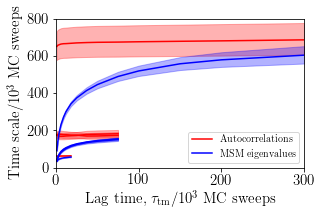

In [ ]:
dtrajs=list(np.load('data/dtrajs/BPTI.npy'))

lags=[1,2,3,4,6,9,12,18,25,37,50,75,100,150,200,300]
nlags=len(lags)
ntrajs=16
d=4
tscales_ev=np.zeros((ntrajs+1,nlags,d))
tscales_ac=np.zeros((ntrajs+1,nlags,d))

en=[i for i in range(ntrajs)]

for k,msm_lag in enumerate(lags):
    M=msm.estimate_markov_model(dtrajs, msm_lag)

    Yt=[]

    for dtraj in M.discrete_trajectories_full:
        Yt.append(np.vstack([M.eigenvectors_right()[i,1:d+1] for i in dtraj]))
    
    s=[np.sum(traj, axis=0) for traj in Yt]
    ssq=[np.diag(np.dot(traj.T,traj)) for traj in Yt]
    n=[traj.shape[0] for traj in Yt]
    
    ac=[[np.diag(np.dot((traj[:-lag,:]).T,traj[lag:,:])) for traj in Yt] for lag in range(1,1001)]

    for skip in range(ntrajs+1):
        mean=np.zeros(d)
        var=np.zeros(d)
        N=0
        for i in (en[:skip]+en[skip+1:]):
            mean+=s[i]
            var+=ssq[i]
            N+=n[i]
        mean/=N
        var=var/(N-1)
        var-=N/(N-1)*mean*mean

        autocorr=np.zeros((1000,d))
        for lag in range(1,1001):
            N=0
            for i in (en[:skip]+en[skip+1:]):
                autocorr[lag-1,:]+=ac[lag-1][i]
                N+=n[i]-lag
            autocorr[lag-1,:]/=N
            autocorr[lag-1,:]-=mean*mean
            autocorr[lag-1,:]/=var

        for i in range(d):
            start=0
            while autocorr[start,i]>.8:
                start+=1
            end=start
            while end < 1000 and autocorr[end,i]>.2:
                end+=1
            A=np.vstack((np.arange(start,end),np.ones(end-start))).T
            if start!=end:
                slope=np.linalg.lstsq(A,np.log(autocorr[start:end,i]))[0][0]
            else:
                slope=float('nan')
            tscales_ev[skip,k,i]=-msm_lag/np.log(autocorr[msm_lag-1,i])
            tscales_ac[skip,k,i]=-1/slope

# transform tscales to avoid numerical problems
tscales_ev=np.log(tscales_ev)
tscales_ac=np.log(tscales_ac)

# jackknife variables
jk_ev=ntrajs*np.tile(tscales_ev[-1,:,:],(ntrajs,1,1))-(ntrajs-1)*tscales_ev[:-1,:,:]
jk_ac=ntrajs*np.tile(tscales_ac[-1,:,:],(ntrajs,1,1))-(ntrajs-1)*tscales_ac[:-1,:,:]

ev_av=np.mean(jk_ev,axis=0)
ac_av=np.mean(jk_ac,axis=0)

ev_std=(np.var(jk_ev,axis=0)/ntrajs)**.5
ac_std=(np.var(jk_ac,axis=0)/ntrajs)**.5



fig=plt.figure(figsize=(12/2.54,8/2.54))
ax=plt.axes()

npts=[-1,12,12,8]
ax.plot(lags,np.exp(ac_av[:,0]), color='r', label='Autocorrelations')
ax.fill_between(lags,np.exp(ac_av[:,0]-ac_std[:,0]),np.exp(ac_av[:,0]+ac_std[:,0]),color='r', alpha=.3)
for i in range(1,d):
    ax.plot(lags[:npts[i]],np.exp(ac_av[:npts[i],i]), color='r')
    ax.fill_between(lags[:npts[i]],np.exp(ac_av[:npts[i],i]-ac_std[:npts[i],i]),np.exp(ac_av[:npts[i],i]+ac_std[:npts[i],i]),color='r', alpha=.3)

ax.plot(lags,np.exp(ev_av[:,0]), color='b', label='MSM eigenvalues')
ax.fill_between(lags,np.exp(ev_av[:,0]-ev_std[:,0]),np.exp(ev_av[:,0]+ev_std[:,0]),color='b', alpha=.3)
for i in range(1,d):
    ax.plot(lags[:npts[i]],np.exp(ev_av[:npts[i],i]), color='b')
    ax.fill_between(lags[:npts[i]],np.exp(ev_av[:npts[i],i]-ev_std[:npts[i],i]),np.exp(ev_av[:npts[i],i]+ev_std[:npts[i],i]),color='b', alpha=.3)
    
ax.legend(loc='lower right', prop={'size':10})

ax.set_ylim([0,800])
ax.set_xlim([0,300])

ax.set_xlabel('Lag time, $\\tau_\mathrm{tm}$/$10^3$ MC sweeps')
ax.set_ylabel('Time scale/$10^3$ MC sweeps')

plt.tight_layout()

plt.savefig("figs/tscales_BPTI.pdf")
plt.show()

plt.gcf().clear()

In [ ]:
dtrajs=list(np.load('dtrajs/GB1.npy'))

lags=[1,2,3,4,6,9,12,18,25,37,50,75,100,150,200,300,400,600]
nlags=len(lags)
ntrajs=NGB1
d=4
tscales_ev=np.zeros((ntrajs+1,nlags,d))
tscales_ac=np.zeros((ntrajs+1,nlags,d))

en=[i for i in range(ntrajs)]

fp=open('tmp','w')
for k,msm_lag in enumerate(lags):
    fp.write(str(msm_lag)+'\n')
    M=msm.estimate_markov_model(dtrajs, msm_lag)

    Yt=[]

    for dtraj in M.discrete_trajectories_full:
        Yt.append(np.vstack([M.eigenvectors_right()[i,1:d+1] for i in dtraj]))
        
    s=[np.sum(traj, axis=0) for traj in Yt]
    ssq=[np.diag(np.dot(traj.T,traj)) for traj in Yt]
    n=[traj.shape[0] for traj in Yt]
    
    ac=[[np.diag(np.dot((traj[:-lag,:]).T,traj[lag:,:])) for traj in Yt] for lag in range(1,1001)]

    for skip in range(ntrajs+1):
        fp.write('\t'+str(skip)+'\n')
        mean=np.zeros(d)
        var=np.zeros(d)
        N=0
        for i in (en[:skip]+en[skip+1:]):
            mean+=s[i]
            var+=ssq[i]
            N+=n[i]
        mean/=N
        var=var/(N-1)
        var-=N/(N-1)*mean*mean

        autocorr=np.zeros((1000,d))
        for lag in range(1,1001):
            N=0
            for i in (en[:skip]+en[skip+1:]):
                autocorr[lag-1,:]+=ac[lag-1][i]
                N+=n[i]-lag
            autocorr[lag-1,:]/=N
            autocorr[lag-1,:]-=mean*mean
            autocorr[lag-1,:]/=var

        for i in range(d):
            start=0
            while autocorr[start,i]>.8:
                start+=1
            end=start
            while end < 1000 and autocorr[end,i]>.2:
                end+=1
            A=np.vstack((np.arange(start,end),np.ones(end-start))).T
            if start!=end:
                slope=np.linalg.lstsq(A,np.log(autocorr[start:end,i]))[0][0]
            else:
                slope=float('nan')
            tscales_ev[skip,k,i]=-msm_lag/np.log(autocorr[msm_lag-1,i])
            tscales_ac[skip,k,i]=-1/slope
fp.close()

# transform tscales to avoid numerical problems
tscales_ev=np.log(tscales_ev)
tscales_ac=np.log(tscales_ac)

# jackknife variables
jk_ev=ntrajs*np.tile(tscales_ev[-1,:,:],(ntrajs,1,1))-(ntrajs-1)*tscales_ev[:-1,:,:]
jk_ac=ntrajs*np.tile(tscales_ac[-1,:,:],(ntrajs,1,1))-(ntrajs-1)*tscales_ac[:-1,:,:]

ev_av=np.mean(jk_ev,axis=0)
ac_av=np.mean(jk_ac,axis=0)

ev_std=(np.var(jk_ev,axis=0)/ntrajs)**.5
ac_std=(np.var(jk_ac,axis=0)/ntrajs)**.5

fig=plt.figure(figsize=(12/2.54,8/2.54))
ax=plt.axes()

npts=[-1,14,14,9]
ax.plot(lags,np.exp(ac_av[:,0]), color='r', label='Autocorrelations')
ax.fill_between(lags,np.exp(ac_av[:,0]-ac_std[:,0]),np.exp(ac_av[:,0]+ac_std[:,0]),color='r', alpha=.3)
for i in range(1,d):
    ax.plot(lags[:npts[i]],np.exp(ac_av[:npts[i],i]), color='r')
    ax.fill_between(lags[:npts[i]],np.exp(ac_av[:npts[i],i]-ac_std[:npts[i],i]),np.exp(ac_av[:npts[i],i]+ac_std[:npts[i],i]),color='r', alpha=.3)

ax.plot(lags,np.exp(ev_av[:,0]), color='b', label='MSM eigenvalues')
ax.fill_between(lags,np.exp(ev_av[:,0]-ev_std[:,0]),np.exp(ev_av[:,0]+ev_std[:,0]),color='b', alpha=.3)
for i in range(1,d):
    ax.plot(lags[:npts[i]],np.exp(ev_av[:npts[i],i]), color='b')
    ax.fill_between(lags[:npts[i]],np.exp(ev_av[:npts[i],i]-ev_std[:npts[i],i]),np.exp(ev_av[:npts[i],i]+ev_std[:npts[i],i]),color='b', alpha=.3)
    
ax.legend(loc='lower right', prop={'size':10})

ax.set_ylim([0,1250])
ax.set_xlim([0,600])

ax.set_xlabel('Lag time, $\\tau_\mathrm{tm}$/$10^3$ MC sweeps')
ax.set_ylabel('Time scale/$10^3$ MC sweeps')

plt.tight_layout()

plt.savefig("figs/tscales_GB1.pdf")
plt.show()

plt.gcf().clear()

Finally, we produce plots illustrating the first couple of MSM eigenfunctions, plotted against the first TICs.

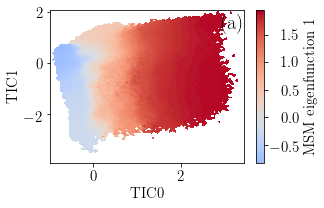

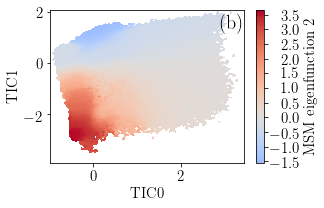

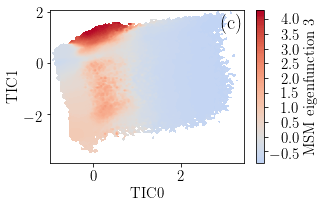

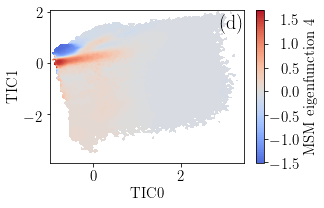

In [17]:
msm_lag=1
Y=np.load('data/TICA-trajs/BPTI.npy')
dtrajs=list(np.load('data/dtrajs/BPTI.npy'))
M = msm.estimate_markov_model(dtrajs, msm_lag)

for d1 in range(d):
    for d2 in range(d1+1,d):
        eigfunc = [numpy.hstack([M.eigenvectors_right()[:,i][dtraj] for dtraj in M.discrete_trajectories_full]) for i in range(1, 11)]

tic0 = numpy.vstack(Y)[:,0]
tic1 = numpy.vstack(Y)[:,1]

def plotEigf(i,x,y,ctickrange,ctickscale,xlabel,ylabel):
    fig=plt.figure(figsize=(12/2.54,8/2.54))
    ax=plt.axes()
    vm=np.max(np.abs(eigfunc[i-1]))

    z,ext=bin_data(x,y,eigfunc[i-1])
    c=ax.contourf(z.T, 100, extent=ext, cmap=cm.coolwarm, vmax=vm, vmin=-vm)
    
    cbar = matplotlib.pyplot.colorbar(c, ax=ax)
    cbar.ax.set_ylabel('MSM eigenfunction %i'%i)
    cbar.set_ticks(np.arange(-ctickrange,ctickrange,ctickscale))
    yticklabs=cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(yticklabs,ha='right')
    cbar.ax.yaxis.set_tick_params(pad=33)
    
    ax.set_aspect('auto')
    ax.set_xlabel('TIC0')
    ax.set_ylabel('TIC1')

    return fig,ax

# Eigenfunction 1
fig,ax=plotEigf(1,tic0,tic1,5,.5,'TIC0','TIC1')
ax.text(2.91,1.35, '(a)', fontsize=20, color='black')
plt.tight_layout()
plt.savefig("figs/eigenfunction1_BPTI.pdf")
plt.show()
plt.gcf().clear()

# Eigenfunction 2
fig,ax=plotEigf(2,tic0,tic1,5,.5,'TIC0','TIC1')
ax.text(2.89,1.35, '(b)', fontsize=20, color='black')
plt.tight_layout()
plt.savefig("figs/eigenfunction2_BPTI.pdf")
plt.show()
plt.gcf().clear()

# Eigenfunction 3
fig,ax=plotEigf(3,tic0,tic1,5,.5,'TIC0','TIC1')
ax.text(2.91,1.35, '(c)', fontsize=20, color='black')
plt.tight_layout()
plt.savefig("figs/eigenfunction3_BPTI.pdf")
plt.show()
plt.gcf().clear()

# Eigenfunction 4
fig,ax=plotEigf(4,tic0,tic1,5,.5,'TIC0','TIC1')
ax.text(2.89,1.35, '(d)', fontsize=20, color='black')
plt.tight_layout()
plt.savefig("figs/eigenfunction3_BPTI.pdf")
plt.show()
plt.gcf().clear()

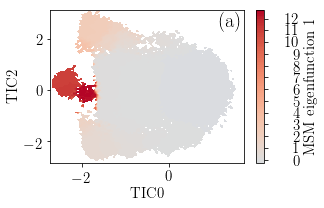

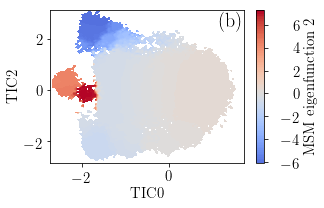

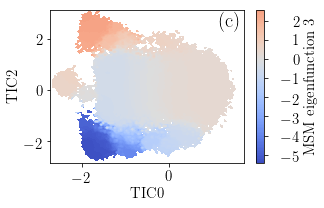

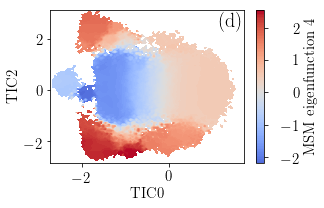

In [23]:
msm_lag=25
Y=np.load('data/TICA-trajs/GB1.npy')
dtrajs=list(np.load('data/dtrajs/GB1.npy'))
M = msm.estimate_markov_model(dtrajs_GB1, msm_lag)

for d1 in range(d):
    for d2 in range(d1+1,d):
        eigfunc = [numpy.hstack([M.eigenvectors_right()[:,i][dtraj] for dtraj in M.discrete_trajectories_full]) for i in range(1, 11)]

tic0 = numpy.vstack(Y)[:,0]
tic1 = numpy.vstack(Y)[:,1]  
tic2 = numpy.vstack(Y)[:,2]  

def plotEigf(i,x,y,ctickrange,ctickscale,xlabel,ylabel):
    fig=plt.figure(figsize=(12/2.54,8/2.54))
    ax=plt.axes()
    vm=np.max(np.abs(eigfunc[i-1]))

    z,ext=bin_data(x,y,eigfunc[i-1])
    c=ax.contourf(z.T, 100, extent=ext, cmap=cm.coolwarm, vmax=vm, vmin=-vm)
    
    cbar = matplotlib.pyplot.colorbar(c, ax=ax)
    cbar.ax.set_ylabel('MSM eigenfunction %i'%i)
    cbar.set_ticks(np.arange(-ctickrange,ctickrange,ctickscale))
    yticklabs=cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(yticklabs,ha='right')
    cbar.ax.yaxis.set_tick_params(pad=33)
    
    ax.set_aspect('auto')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    return fig,ax


# Eigenfunction 1
fig,ax=plotEigf(1,tic0,tic2,20,1,'TIC0','TIC2')
ax.text(1.15,2.5, '(a)', fontsize=20, color='black')
plt.tight_layout()
plt.savefig("figs/eigenfunction1_GB1.pdf")
plt.show()
plt.gcf().clear()

# Eigenfunction 2
fig,ax=plotEigf(2,tic0,tic2,20,2,'TIC0','TIC2')
ax.text(1.15,2.5, '(b)', fontsize=20, color='black')
plt.tight_layout()
plt.savefig("figs/eigenfunction2_GB1.pdf")
plt.show()
plt.gcf().clear()

# Eigenfunction 3
fig,ax=plotEigf(3,tic0,tic2,20,1,'TIC0','TIC2')
ax.text(1.15,2.5, '(c)', fontsize=20, color='black')
plt.tight_layout()
plt.savefig("figs/eigenfunction3_GB1.pdf")
plt.show()
plt.gcf().clear()

# Eigenfunction 4
fig,ax=plotEigf(4,tic0,tic2,20,1,'TIC0','TIC2')
ax.text(1.15,2.5, '(d)', fontsize=20, color='black')
plt.tight_layout()
plt.savefig("figs/eigenfunction3_GB1.pdf")
plt.show()
plt.gcf().clear()